In [5]:
import pandas as pd
import numpy as np
import re
import nltk
import os
import zipfile
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from spacy.cli import download
download('pt_core_news_sm')
nlp = spacy.load('pt_core_news_sm')
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, AffinityPropagation # Corrected the import statement
from sklearn.feature_extraction.text import TfidfVectorizer

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
from google.colab import files
uploaded = files.upload()

Saving archive (3).zip to archive (3).zip


In [6]:
caminho_zip = '/content/archive (3).zip'
pasta_destino = 'texto'

In [7]:
caminho_zip = '/content/archive (3).zip'

if os.path.exists(caminho_zip):
    with zipfile.ZipFile(caminho_zip, 'r') as zip_ref:
        zip_ref.extractall(pasta_destino)
        print(f'Arquivos extraídos para {pasta_destino}')
else:
    print(f'Arquivo não encontrado: {caminho_zip}')


Arquivos extraídos para texto


In [8]:
import pandas as pd

# Caminho para o arquivo TSV extraído
caminho_tsv = '/content/texto/dadosTextosCientificos.tsv'

# Carregar a base de dados (TSV usa tabulação como separador)
# Added encoding='latin1' to handle different character encoding
df = pd.read_csv(caminho_tsv, sep='\t', encoding='latin1')

# Mostrar as primeiras linhas da base de dados
print(df.head())


                                      Título_Público  \
0  Açúcar de frutas e aplicação em bolos como sub...   
1  Desenvolver uma linha de farofas com castanhas...   
2  Desenvolvimento de cobertura líquida para sorvete   
3       Desenvolvimento de conserva de tomate cereja   
4  Desenvolvimento de massa alimentícia enriqueci...   

                                   Descricao_pública  
0  O uso de inovações tecnológicas auxilia as ind...  
1  O uso de inovações tecnológicas auxilia as ind...  
2  O Brasil é considerado um país com a maior bio...  
3  O Brasil é considerado o país com maior biodiv...  
4  Nos últimos anos a comunidade científica tem d...  


In [9]:
df.shape

(2725, 2)

In [10]:
df.dtypes

,0
Título_Público,object
Descricao_pública,object


In [11]:
df_limpo = df.dropna()

In [12]:
# Cópia do DataFrame original/ faremos essa copia para evitar o avisos como SettingWithCopyWarning
df_limpo = df_limpo.copy()

# aqui ja vai sem o aviso
df_limpo['texto_completo'] = df_limpo['Título_Público'] + ' ' + df_limpo['Descricao_pública']

In [13]:
# aqui vamos limpar o texto para conseguir ultilizar mais tarde
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\W', ' ', text)
    return text

df_limpo.loc[:, 'texto_completo'] = df_limpo['texto_completo'].apply(lambda x: clean_text(x))

In [14]:
# baixando recurso usado em NLTK (Natural Language Toolkit) para fazer tokenização
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
# baixando recurso usado em NLTK (Natural Language Toolkit) para fazer tokenização
nltk.download('punkt')
nltk.download('stopwords')
# Download the 'punkt_tab' resource
nltk.download('punkt_tab') # This line was added to download the necessary resource
stop_words = set(stopwords.words('portuguese'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [18]:
# Função para extrair entidades ('ORG', 'PERSON', 'LOC')
def extract_entities(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents if ent.label_ in ('ORG', 'PERSON', 'LOC')]
    return ' '.join(entities)

In [19]:
# Aplicar NER (Reconhecimento de Entidades Nomeadas) na coluna 'texto_completo'
df_limpo.loc[:, 'entities'] = df_limpo['texto_completo'].apply(extract_entities)

In [22]:
# Lematização dos textoAçúcar de frutas e aplicação em ent.label_) for ent in doc.ents]
import spacy

# Load the spaCy model with lemmatization capabilities
nlp = spacy.load('pt_core_news_sm')

# Define the lemmatization function
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

# Extração de expressões multi-palavra
def multi_word_expressions(text):
    doc = nlp(text)
    return [token.text for token in doc if token.is_alpha and len(token.text.split()) > 1]

# Extração de verbos
def extract_verb_phrases(text):
    doc = nlp(text)
    return [token.text for token in doc if token.pos_ == 'VERB']

# Aplicando as funções no DataFrame
df_limpo.loc[:, 'texto_completo'] = df_limpo['texto_completo'].apply(lambda x: lemmatize_text(x))
df_limpo.loc[:, 'entities'] = df_limpo['texto_completo'].apply(lambda x: extract_entities(x))
df_limpo.loc[:, 'multi_word_expressions'] = df_limpo['texto_completo'].apply(lambda x: multi_word_expressions(x))
df_limpo.loc[:, 'verb_phrases'] = df_limpo['texto_completo'].apply(lambda x: extract_verb_phrases(x))

In [25]:
# Combinar as colunas de interesse (lemmatizações, entidades, expressões multi-palavra, verbos)
df_limpo.loc[:, 'combined_text'] = df_limpo.apply(
    lambda x: x['texto_completo'] + ' ' +
              x['entities'] + ' ' +
              ' '.join(x['multi_word_expressions']) + ' ' +
              ' '.join(x['verb_phrases']), axis=1
)

# Criar a matriz TF-IDF
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(df_limpo['combined_text'])

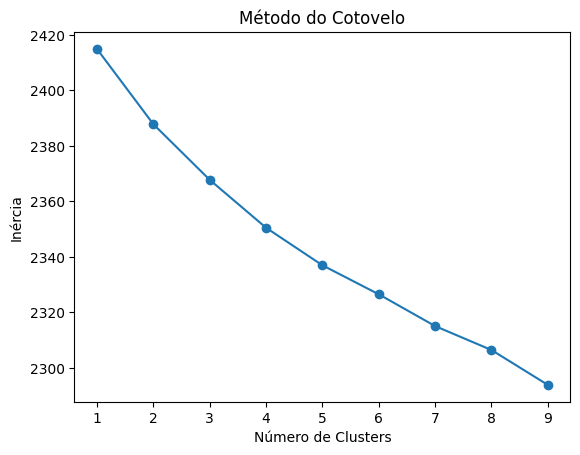

In [26]:
# Lista para armazenar a inércia
inertia = []

# Definir o intervalo de clusters a testar
cluster_range = range(1, 10)

# Loop para calcular a inércia para cada valor de k
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_tfidf)
    inertia.append(kmeans.inertia_)

# Plotar o gráfico do método do cotovelo
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.show()

In [27]:
# Função para avaliar os clusters
def evaluate_clusters(X, labels, model_name):
    silhouette_avg = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    calinski_harabasz = calinski_harabasz_score(X, labels)

    result = {
        'Model': model_name,
        'Silhouette Score': silhouette_avg,
        'Davies-Bouldin Index': davies_bouldin,
        'Calinski-Harabasz Index': calinski_harabasz
    }

    print(f"{model_name} Cluster Evaluation:")
    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Davies-Bouldin Index: {davies_bouldin}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz}")
    print("----------------------------------------")

    return result

In [29]:
# Inicializando a lista de resultados
results = []

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

# K-Means
kmeans = KMeans(n_clusters=7, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)
results.append(evaluate_clusters(X_pca, kmeans_labels, 'K-Means with PCA'))

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca)
if len(set(dbscan_labels)) > 1:
    results.append(evaluate_clusters(X_pca, dbscan_labels, 'DBSCAN with PCA'))

# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=7)
agg_labels = agg.fit_predict(X_pca)
results.append(evaluate_clusters(X_pca, agg_labels, 'Agglomerative Clustering with PCA'))

# Affinity Propagation
affinity = AffinityPropagation(damping=0.9, random_state=42)
aff_labels = affinity.fit_predict(X_pca)
results.append(evaluate_clusters(X_pca, aff_labels, 'Affinity Propagation with PCA'))


K-Means with PCA Cluster Evaluation:
Silhouette Score: 0.3200526409344628
Davies-Bouldin Index: 0.9023044691223353
Calinski-Harabasz Index: 1580.2417087289853
----------------------------------------
Agglomerative Clustering with PCA Cluster Evaluation:
Silhouette Score: 0.2869196831984861
Davies-Bouldin Index: 0.9371392803613227
Calinski-Harabasz Index: 1324.5684099223372
----------------------------------------
Affinity Propagation with PCA Cluster Evaluation:
Silhouette Score: 0.3414115259812751
Davies-Bouldin Index: 0.7915364403590824
Calinski-Harabasz Index: 1695.707399559158
----------------------------------------


In [30]:
# TSNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_tfidf.toarray())

# Avaliando clusters com K-Means em t-SNE
kmeans_tsne = KMeans(n_clusters=7, n_init=10, random_state=42)
kmeans_labels_tsne = kmeans_tsne.fit_predict(X_tsne)
results.append(evaluate_clusters(X_tsne, kmeans_labels_tsne, 'K-Means with t-SNE'))

# Avaliando clusters com DBSCAN em t-SNE
dbscan_tsne = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels_tsne = dbscan_tsne.fit_predict(X_tsne)
if len(set(dbscan_labels_tsne)) > 1:
    results.append(evaluate_clusters(X_tsne, dbscan_labels_tsne, 'DBSCAN with t-SNE'))

# Avaliando clusters com Agglomerative Clustering em t-SNE
agg_tsne = AgglomerativeClustering(n_clusters=7)
agg_labels_tsne = agg_tsne.fit_predict(X_tsne)
results.append(evaluate_clusters(X_tsne, agg_labels_tsne, 'Agglomerative Clustering with t-SNE'))

# Avaliando clusters com Affinity Propagation em t-SNE
affinity_tsne = AffinityPropagation(damping=0.9, random_state=42)
aff_labels_tsne = affinity_tsne.fit_predict(X_tsne)
results.append(evaluate_clusters(X_tsne, aff_labels_tsne, 'Affinity Propagation com t-SNE'))

K-Means with t-SNE Cluster Evaluation:
Silhouette Score: 0.34990379214286804
Davies-Bouldin Index: 0.8328618819943118
Calinski-Harabasz Index: 2008.745849609375
----------------------------------------
DBSCAN with t-SNE Cluster Evaluation:
Silhouette Score: -0.5567669868469238
Davies-Bouldin Index: 1.0073732416603611
Calinski-Harabasz Index: 13.352543830871582
----------------------------------------
Agglomerative Clustering with t-SNE Cluster Evaluation:
Silhouette Score: 0.2538508474826813
Davies-Bouldin Index: 0.9216808216740608
Calinski-Harabasz Index: 1566.6259765625
----------------------------------------
Affinity Propagation com t-SNE Cluster Evaluation:
Silhouette Score: 0.35131821036338806
Davies-Bouldin Index: 0.7826822084250885
Calinski-Harabasz Index: 2095.59521484375
----------------------------------------


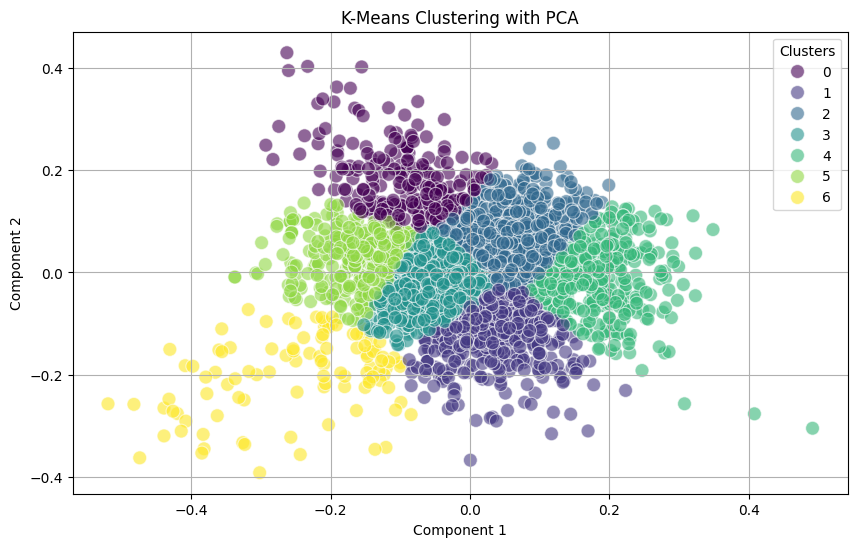

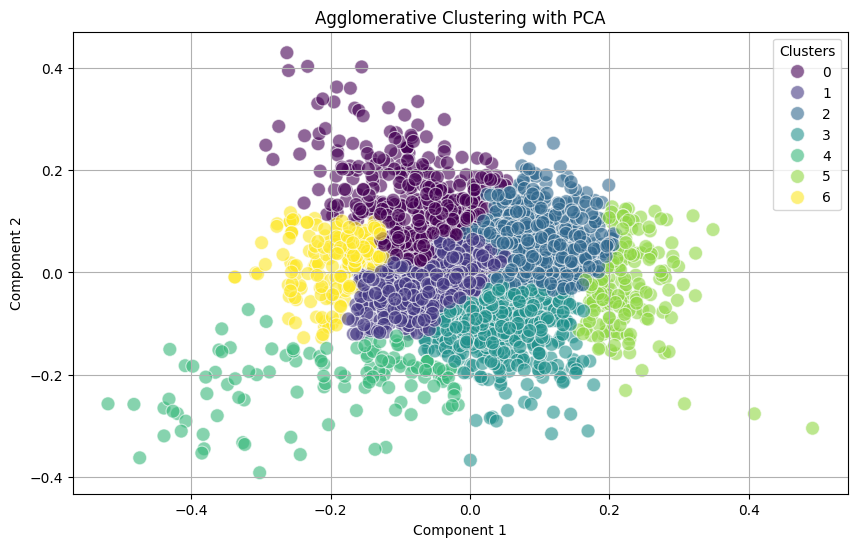

In [31]:
import seaborn as sns
# Função para visualizar os clusters
def plot_clusters(X, labels, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette='viridis', s=100, alpha=0.6, edgecolor='w')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend(title='Clusters')
    plt.grid(True)
    plt.show()

# Visualizando K-Means com PCA
plot_clusters(X_pca, kmeans_labels, 'K-Means Clustering with PCA')

# Visualizando Agglomerative Clustering com PCA
plot_clusters(X_pca, agg_labels, 'Agglomerative Clustering with PCA')


In [49]:
def get_top_n_words_per_cluster(X_tfidf, labels, n=10):
    # Criar um DataFrame para armazenar as palavras e suas pontuações
    df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())  # Usar 'tfidf'
    df_tfidf['Cluster'] = labels

    top_words_per_cluster = {}

    for cluster in np.unique(labels):
        cluster_words = df_tfidf[df_tfidf['Cluster'] == cluster].drop(columns='Cluster')
        mean_values = cluster_words.mean(axis=0)
        top_words = mean_values.nlargest(n).index.tolist()
        top_words_per_cluster[cluster] = top_words

    return top_words_per_cluster

top_words_kmeans = get_top_n_words_per_cluster(X_tfidf, kmeans_labels)
top_words_agg = get_top_n_words_per_cluster(X_tfidf, agg_labels)

print("Top palavras para K-Means:")
for cluster, words in top_words_kmeans.items():
    print(f"Cluster {cluster}: {words}")

print("\nTop palavras para Agglomerative Clustering:")
for cluster, words in top_words_agg.items():
    print(f"Cluster {cluster}: {words}")

Top palavras para K-Means:
Cluster 0: ['desenvolver', 'de', 'para', 'em', 'um', 'utilizar', 'projeto', 'pesquisar', 'ser', 'com']
Cluster 1: ['de', 'desenvolvimento', 'para', 'sistema', 'em', 'um', 'software', 'dado', 'solução', 'monitoramento']
Cluster 2: ['de', 'em', 'desenvolver', 'ser', 'para', 'um', 'visar', 'ter', 'utilizar', 'projeto']
Cluster 3: ['de', 'para', 'desenvolvimento', 'em', 'um', 'com', 'sistema', 'basear', 'solução', 'por']
Cluster 4: ['de', 'em', 'ser', 'um', 'processo', 'para', 'ter', 'que', 'projeto', 'por']
Cluster 5: ['de', 'para', 'desenvolvimento', 'em', 'novo', 'com', 'desenvolver', 'sistema', 'um', 'aplicação']
Cluster 6: ['embarcar', 'software', 'de', 'para', 'plataforma', 'integrar', 'dispositivo', 'sistema', 'gerenciamento', 'basear']

Top palavras para Agglomerative Clustering:
Cluster 0: ['de', 'desenvolver', 'para', 'em', 'um', 'utilizar', 'com', 'visar', 'projeto', 'ser']
Cluster 1: ['de', 'para', 'desenvolvimento', 'em', 'um', 'com', 'sistema', 'sol

In [34]:
k_ideal = 4
kmeans_final = KMeans(n_clusters=k_ideal)
kmeans_final.fit(X_pca)
labels = kmeans_final.labels_


In [35]:
df_limpo['Cluster'] = labels

In [40]:
centroids = kmeans_final.cluster_centers_

In [41]:
# Contar quantos itens pertencem a cada cluster
contagem_clusters = df_limpo['Cluster'].value_counts()
print(contagem_clusters)

# Exibir algumas descrições para cada cluster
for cluster_num in range(k_ideal):
    print(f"Cluster {cluster_num}:")
    print(df_limpo[df_limpo['Cluster'] == cluster_num][['Título_Público', 'Descricao_pública']].head())
    print("\n")


Cluster
3    863
1    816
0    781
2    261
Name: count, dtype: int64
Cluster 0:
                                       Título_Público  \
10  Fertilizantes organominerais formulados a part...   
13  Vida útil de castanha de baru torrada acondici...   
15  AGILE - Engrenagens de manufatura aditiva com ...   
23           HUAWEI SOLAR TRACKING CONTROL (AI BASED)   
66                                        CLOUDISH-II   

                                    Descricao_pública  
10  O presente contrato gerará um produto inovador...  
13  Desenvolver e avaliar revestimentos biodegradá...  
15  Projeto para mapear o potencial de engrenagens...  
23  O Objetivo deste projeto consiste no desenvolv...  
66  Simulador para avaliar a viabilidade do escalo...  


Cluster 1:
                                       Título_Público  \
22  HUAWEI - PV generation with optimal BESS based...   
24                                     Siemens-Energy   
26  Sistema de Localização de Pontos de Derivação ...   

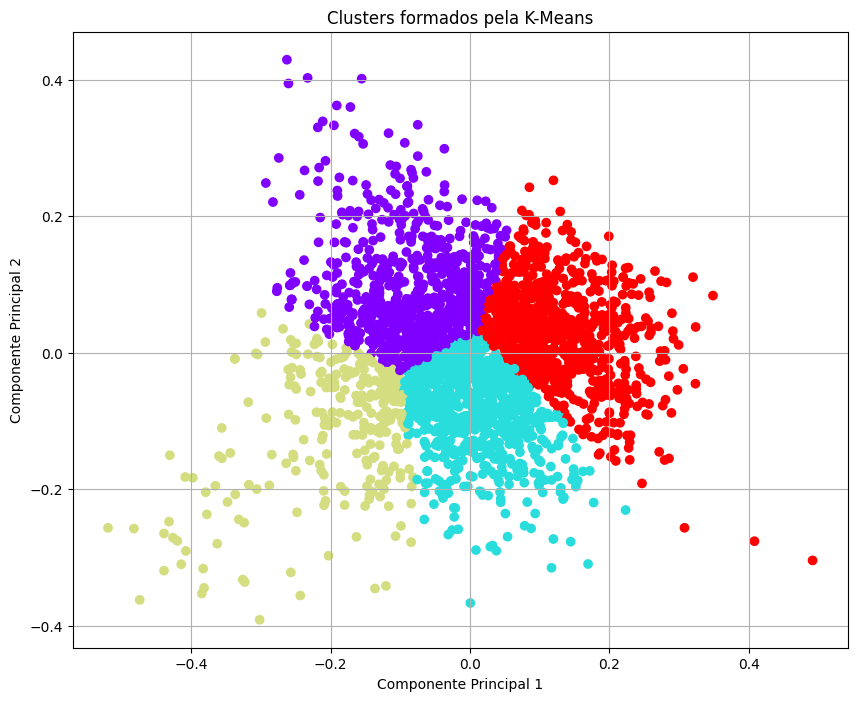

In [38]:
import matplotlib.pyplot as plt

# Plotar os clusters gerados pelo K-Means
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_limpo['Cluster'], cmap='rainbow')
plt.title('Clusters formados pela K-Means')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()


In [42]:
from sklearn.metrics import silhouette_score

# Calculando o Silhouette Score
silhouette_avg = silhouette_score(X_pca, labels)
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.3321333893701507


In [44]:
for cluster_num in range(k_ideal):
    print(f"Cluster {cluster_num}:")
    print(df_limpo[df_limpo['Cluster'] == cluster_num][['Título_Público', 'Descricao_pública']].head())
    print("\n")

Cluster 0:
                                       Título_Público  \
10  Fertilizantes organominerais formulados a part...   
13  Vida útil de castanha de baru torrada acondici...   
15  AGILE - Engrenagens de manufatura aditiva com ...   
23           HUAWEI SOLAR TRACKING CONTROL (AI BASED)   
66                                        CLOUDISH-II   

                                    Descricao_pública  
10  O presente contrato gerará um produto inovador...  
13  Desenvolver e avaliar revestimentos biodegradá...  
15  Projeto para mapear o potencial de engrenagens...  
23  O Objetivo deste projeto consiste no desenvolv...  
66  Simulador para avaliar a viabilidade do escalo...  


Cluster 1:
                                       Título_Público  \
22  HUAWEI - PV generation with optimal BESS based...   
24                                     Siemens-Energy   
26  Sistema de Localização de Pontos de Derivação ...   
27                                    5G-EdgeServices   
29          

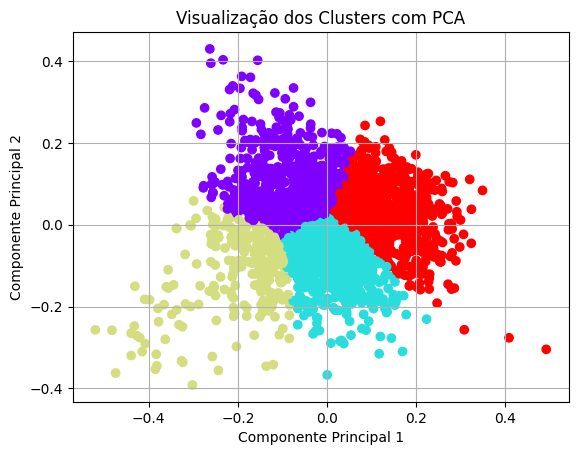

In [45]:
import matplotlib.pyplot as plt

# Visualizar os clusters com as duas primeiras componentes principais
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='rainbow')
plt.title('Visualização dos Clusters com PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()


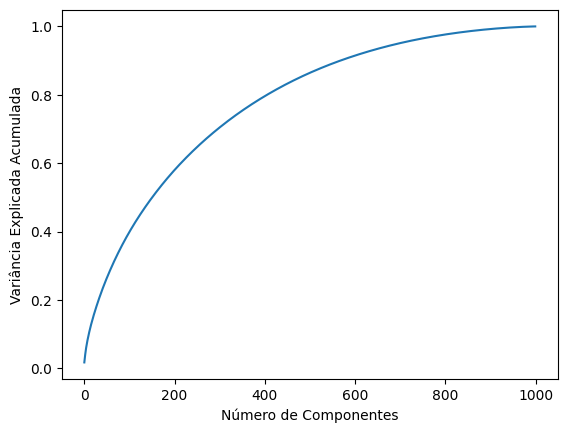

In [46]:
pca = PCA().fit(X_tfidf.toarray())
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.show()


In [48]:
from collections import Counter

for cluster_num in range(k_ideal):
    cluster_texts = df_limpo[df_limpo['Cluster'] == cluster_num]['Descricao_pública']
    all_words = ' '.join(cluster_texts).split()
    most_common_words = Counter(all_words).most_common(10)
    print(f"Cluster {cluster_num}: {most_common_words}")

Cluster 0: [('de', 2019), ('e', 846), ('para', 668), ('a', 598), ('em', 446), ('o', 290), ('um', 272), ('com', 267), ('do', 235), ('projeto', 213)]
Cluster 1: [('de', 3936), ('e', 1234), ('para', 821), ('a', 609), ('em', 481), ('o', 414), ('do', 369), ('um', 349), ('da', 344), ('com', 329)]
Cluster 2: [('de', 571), ('para', 268), ('e', 171), ('Desenvolvimento', 98), ('em', 70), ('a', 56), ('software', 53), ('o', 46), ('com', 40), ('Software', 39)]
Cluster 3: [('de', 8022), ('e', 3096), ('a', 2405), ('o', 1625), ('para', 1464), ('do', 1338), ('em', 1301), ('da', 1228), ('que', 926), ('com', 830)]
